# **Assignment**

## **Provided code to compare images**

```draw_color_mask function``` creates a color mask on an input image, effectively blocking out specified borders with a specified color (default is black). It calculates the coordinates of the borders based on the percentage of the image size and draws rectangles using OpenCV to create the mask.The parameters are  img (The input image), borders(A list representing the percentage of each border left, top, right, bottom) to be covered by the color mask, color (The color of the mask default is black) and **Returns** the modified image with the color mask applied.

```preprocess_image_change_detection``` preprocesses an input image for change detection by converting it to grayscale, applying Gaussian blur, and masking specific regions with a black color.

```compare_frames_change_detection``` compares two consecutive frames to detect changes, such as lightning, movements or significant differences.the parameters are prev_frame(The previous frame), next_frame(The current frame to be compared with the previous one), min_contour_area(The minimum contour area to consider as a significant change) and **Returns** score(A cumulative score representing the total area of contours in the difference between frames), res_cnts(A list of contours that meet the criteria of significant change), thresh(The thresholded image highlighting areas of change)

In [5]:
import cv2
import imutils


def draw_color_mask(img, borders, color=(0, 0, 0)):
    h = img.shape[0]
    w = img.shape[1]

    x_min = int(borders[0] * w / 100)
    x_max = w - int(borders[2] * w / 100)
    y_min = int(borders[1] * h / 100)
    y_max = h - int(borders[3] * h / 100)

    img = cv2.rectangle(img, (0, 0), (x_min, h), color, -1)
    img = cv2.rectangle(img, (0, 0), (w, y_min), color, -1)
    img = cv2.rectangle(img, (x_max, 0), (w, h), color, -1)
    img = cv2.rectangle(img, (0, y_max), (w, h), color, -1)

    return img



def preprocess_image_change_detection(img, gaussian_blur_radius_list=None, black_mask=(5, 10, 5, 0)):
    gray = img.copy()
    gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)
    if gaussian_blur_radius_list is not None:
        for radius in gaussian_blur_radius_list:
            gray = cv2.GaussianBlur(gray, (radius, radius), 0)

    gray = draw_color_mask(gray, black_mask)

    return gray



def compare_frames_change_detection(prev_frame, next_frame, min_contour_area):
    frame_delta = cv2.absdiff(prev_frame, next_frame)
    thresh = cv2.threshold(frame_delta, 45, 255, cv2.THRESH_BINARY)[1]

    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                            cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    score = 0
    res_cnts = []
    for c in cnts:
        if cv2.contourArea(c) < min_contour_area:
            continue

        res_cnts.append(c)
        score += cv2.contourArea(c)

    return score, res_cnts, thresh


## **Task**

Your task is to write a program that will find and remove all similar-looking
images in a folder. The input of the program should be a path to a folder with
images, in the result program should remove all non-essential for data
collection images - duplicated or almost duplicated images that have only
minor differences from the original that may be considered as non-essential.
In the attachment, you will find imaging_interview.py script that
contains functions for image comparison. You should use them to implement
your solution. Use only provided functions for image comparison, there is no
need to develop your own comparison algorithm. We will evaluate how you
write the program to clean the data, not the algorithm you will use.

## **Solution**

### **Trial 1**

#### Reading the images

1. We start with the following 2 images:
    1. c10-1623871124416.png
    2. c10-1623871168398.png

2. We preprocess the images by setting parameters gaussian blur radius to 5 and minimum contour area as 1000. We then pass the parameters to the ```preprocess_image_change_detection``` function for each image.

3. Finally we obtain the comparison score using the ```compare_frames_change_detection``` function which measures the changes in the 2 images.


In [2]:
import cv2
import numpy as np

# Load two example images
image1 = cv2.imread('c10small\c10-1623871124416.png')
image2 = cv2.imread('c10small\c10-1623871168398.png')

# Set parameters
gaussian_blur_radius_list = [5]
min_contour_area = 1000

# Preprocess images
processed_image1 = preprocess_image_change_detection(image1, gaussian_blur_radius_list)
processed_image2 = preprocess_image_change_detection(image2, gaussian_blur_radius_list)

# Compare frames
score, contours, thresholded_diff = compare_frames_change_detection(processed_image1, processed_image2, min_contour_area)

### Visualise changes
We will plot the intermittent steps to visualise the original image, processed image and finally superposition the identified regions of difference via contours.

#### View original images

We notice that the 2 images are nearly identical 

(-0.5, 639.5, 479.5, -0.5)

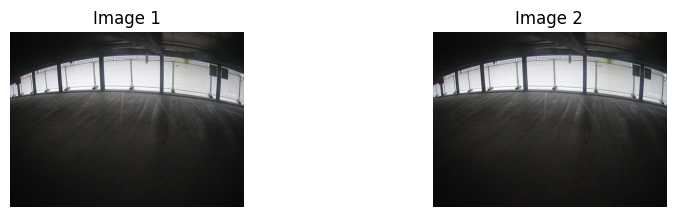

In [3]:
# Display the original images
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.title('Image 1')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.title('Image 2')
plt.axis('off')

#### View processed images

We take a look at both the images after applying the gaussian blur.

(-0.5, 639.5, 479.5, -0.5)

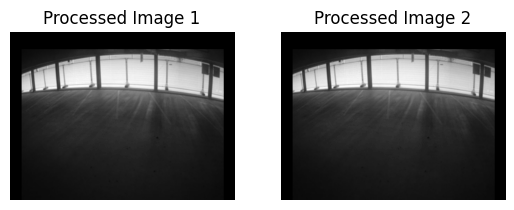

In [5]:
# Display the processed images
plt.subplot(2, 2, 3)
plt.imshow(processed_image1, cmap='gray')
plt.title('Processed Image 1')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(processed_image2, cmap='gray')
plt.title('Processed Image 2')
plt.axis('off')

plt.show()

#### Display Score

We print out the score and number of contours detected which were calculated using the provided ```compare_frames_change_detection``` function.

We notice that the change score is zero which can also be deduced fromt he physically inspecting the images.


In [6]:
# Display the comparison results
print(f"Change Score: {score}")
print(f"Number of Contours: {len(contours)}")

Change Score: 0
Number of Contours: 0


#### Display Contours over original images

If a change contour is detected the below code will draw over the image. 

```cv2.drawContours``` is used to draw contours on the copied images (contour_image1 and contour_image2).

```contours``` is a list of contours obtained from the change detection process.

```-1``` indicates that all contours in the list should be drawn.

```(0, 255, 0)``` is the color of the contours in BGR format, here it's green. 

```2``` is the thickness of the contour lines.

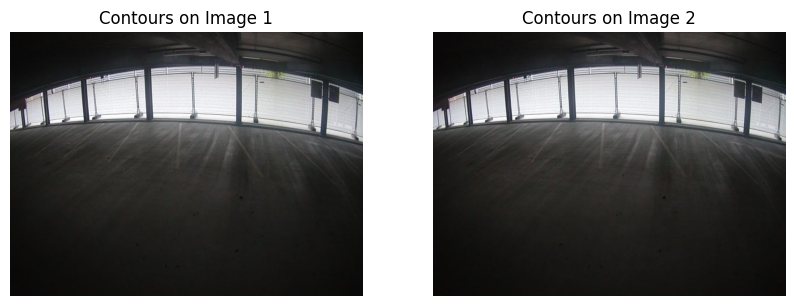

In [8]:
# Draw contours on the original images
contour_image1 = image1.copy()
contour_image2 = image2.copy()
cv2.drawContours(contour_image1, contours, -1, (0, 255, 0), 2)
cv2.drawContours(contour_image2, contours, -1, (0, 255, 0), 2)

# Display the original images with contours
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(contour_image1, cv2.COLOR_BGR2RGB))
plt.title('Contours on Image 1')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(contour_image2, cv2.COLOR_BGR2RGB))
plt.title('Contours on Image 2')
plt.axis('off')

plt.show()

#### Display difference image

```thresholded_diff``` obtained from ```compare_frames_change_detection``` plots an image that only highlights the identical section of the 2 images if it exists in white. 

In this case since there are no differences in the 2 images the image is in black. 

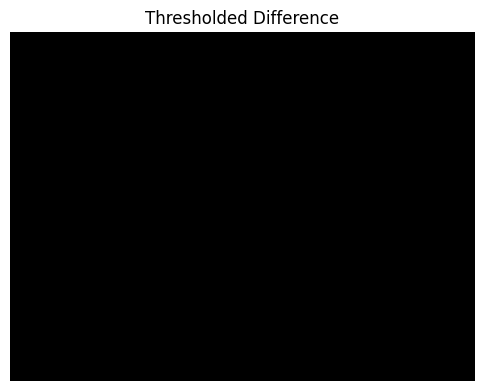

In [9]:
# Display the thresholded difference image
plt.figure(figsize=(6, 6))
plt.imshow(thresholded_diff, cmap='gray')
plt.title('Thresholded Difference')
plt.axis('off')
plt.show()

### **Trial 2**

We test values with different parameters in the next trial

**Compared images**
1. c10-1623871124416.png
2. c10-1623872544167.png

**New parameter values**
1. gaussian_blur_radius_list = [35]
2. min_contour_area = 95


**Observation**

In this trial we notice significant differences in the 2 images. as shown by the white colour in the difference image. 

Therefore it is not wise to delete any of the 2 images.

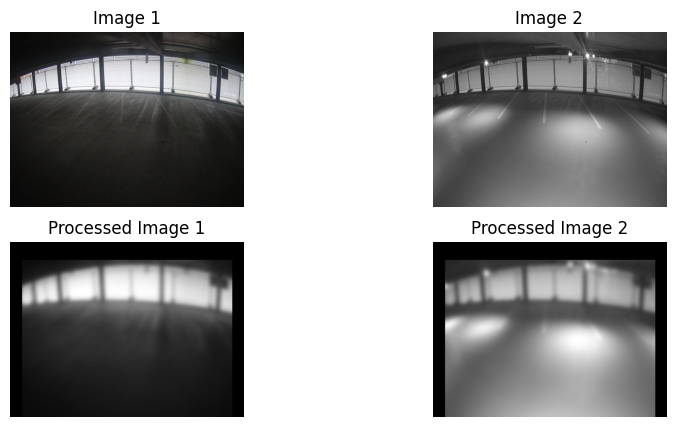

Change Score: 192490.5
Number of Contours: 4


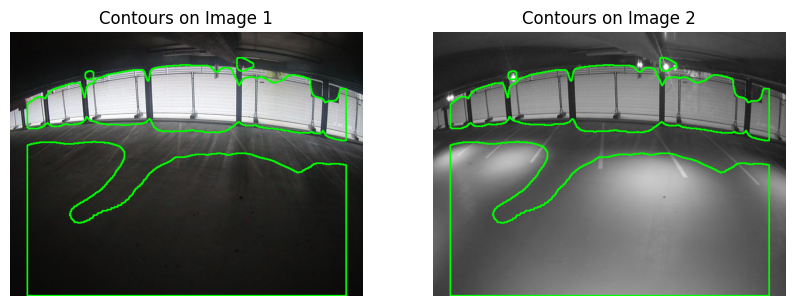

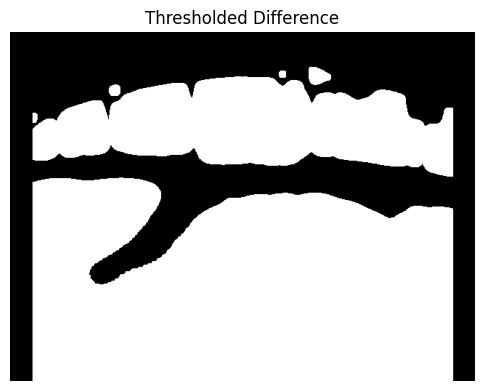

In [69]:
import cv2
import numpy as np

# Load two example images
image1 = cv2.imread('c10small\c10-1623871124416.png')
image2 = cv2.imread('c10small\c10-1623872544167.png')

# Set parameters
gaussian_blur_radius_list = [35]
min_contour_area = 95
black_mask = (5, 10, 5, 0)

# Preprocess images
processed_image1 = preprocess_image_change_detection(image1, gaussian_blur_radius_list, black_mask)
processed_image2 = preprocess_image_change_detection(image2, gaussian_blur_radius_list, black_mask)

# Compare frames
score, contours, thresholded_diff = compare_frames_change_detection(processed_image1, processed_image2, min_contour_area)

# Display the original images
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.title('Image 1')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.title('Image 2')
plt.axis('off')

# Display the processed images
plt.subplot(2, 2, 3)
plt.imshow(processed_image1, cmap='gray')
plt.title('Processed Image 1')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(processed_image2, cmap='gray')
plt.title('Processed Image 2')
plt.axis('off')

plt.show()

# Display the comparison results
print(f"Change Score: {score}")
print(f"Number of Contours: {len(contours)}")

# Draw contours on the original images
contour_image1 = image1.copy()
contour_image2 = image2.copy()
cv2.drawContours(contour_image1, contours, -1, (0, 255, 0), 2)
cv2.drawContours(contour_image2, contours, -1, (0, 255, 0), 2)

# Display the original images with contours
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(contour_image1, cv2.COLOR_BGR2RGB))
plt.title('Contours on Image 1')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(contour_image2, cv2.COLOR_BGR2RGB))
plt.title('Contours on Image 2')
plt.axis('off')

plt.show()

# Display the thresholded difference image
plt.figure(figsize=(6, 6))
plt.imshow(thresholded_diff, cmap='gray')
plt.title('Thresholded Difference')
plt.axis('off')
plt.show()

### **Trial 3**

**Compared Images**

c10-1623871124416.png

c10-1623913758221.png

We notice that there are images with varying resolution. 

To ensure that the code does not fail to compare these images with different dimensions, we convert all the images to a target size before comparing them.

In this trial, we vary the parameter values also to observe the changes in the evaluation

**Parameter Values**

```gaussian_blur_radius_list``` = [25]

```min_contour_area``` = 1000

**Observation**

The code eliminates the problem of variation in image resolution by setting a ```target_resolution``` of ```800x600```.

The code can also correctly identify the changes in the images apart from the lighting conditions, in this case the car.



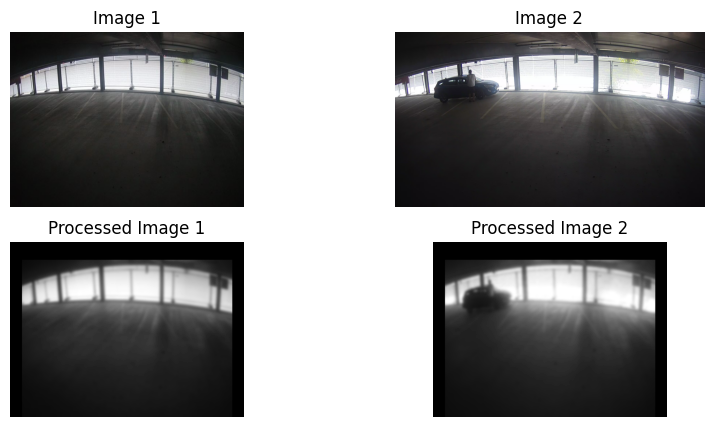

Change Score: 34374.0
Number of Contours: 4


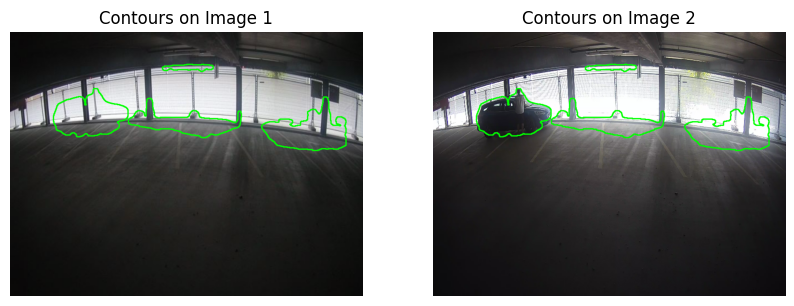

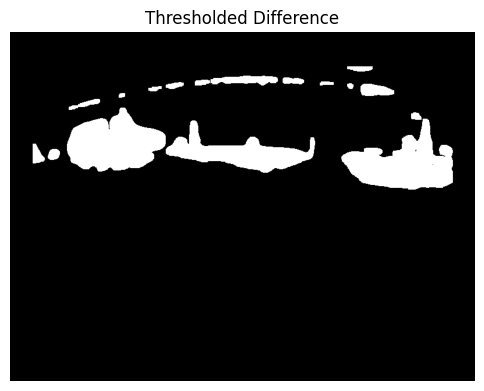

In [76]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def resize_image(image, target_resolution):
    return cv2.resize(image, target_resolution)

# Load two example images
image1 = cv2.imread('c10small\c10-1623871124416.png')
image2 = cv2.imread('c10small\c10-1623913758221.png')

# Choose a common target resolution (adjust as needed)
target_resolution = (800, 600)

# Resize images to the common resolution
resized_image1 = resize_image(image1, target_resolution)
resized_image2 = resize_image(image2, target_resolution)

# Set parameters
gaussian_blur_radius_list = [25]
min_contour_area = 1000
black_mask = (5, 10, 5, 0)

# Preprocess images
processed_image1 = preprocess_image_change_detection(resized_image1, gaussian_blur_radius_list, black_mask)
processed_image2 = preprocess_image_change_detection(resized_image2, gaussian_blur_radius_list, black_mask)

# Compare frames
score, contours, thresholded_diff = compare_frames_change_detection(processed_image1, processed_image2, min_contour_area)

# Display the original images
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.title('Image 1')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.title('Image 2')
plt.axis('off')

# Display the processed images
plt.subplot(2, 2, 3)
plt.imshow(processed_image1, cmap='gray')
plt.title('Processed Image 1')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(processed_image2, cmap='gray')
plt.title('Processed Image 2')
plt.axis('off')

plt.show()

# Display the comparison results
print(f"Change Score: {score}")
print(f"Number of Contours: {len(contours)}")

# Draw contours on the original images
contour_image1 = resized_image1.copy()
contour_image2 = resized_image2.copy()
cv2.drawContours(contour_image1, contours, -1, (0, 255, 0), 2)
cv2.drawContours(contour_image2, contours, -1, (0, 255, 0), 2)

# Display the original images with contours
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(contour_image1, cv2.COLOR_BGR2RGB))
plt.title('Contours on Image 1')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(contour_image2, cv2.COLOR_BGR2RGB))
plt.title('Contours on Image 2')
plt.axis('off')

plt.show()

# Display the thresholded difference image
plt.figure(figsize=(6, 6))
plt.imshow(thresholded_diff, cmap='gray')
plt.title('Thresholded Difference')
plt.axis('off')
plt.show()


## **Trial 4**

**Compared Images**

c20_2021_03_25__16_18_36.png

c20_2021_03_25__16_28_50.png

**Parameter Values**

```gaussian_blur_radius_list``` = [25]

```min_contour_area``` = 1000

**Observation**

A lower change score value of 1193 appeared in this trial. 

Even though the value was low, the change was significant as indicated by the contour image in the code run. The image shows that the car door is opened in 1 and closed in another deeming the significance of keeping both the images. 

*We have now discovered that changes with lower values are also significant.*




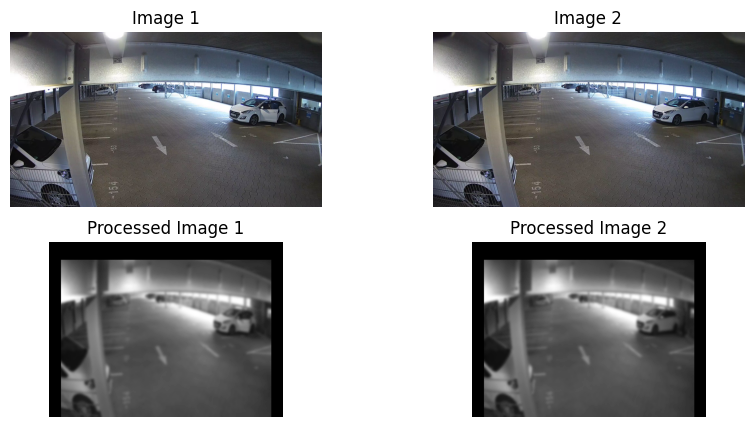

Change Score: 1193.0
Number of Contours: 1


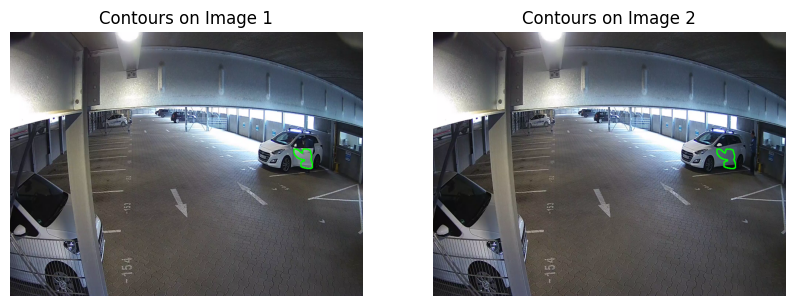

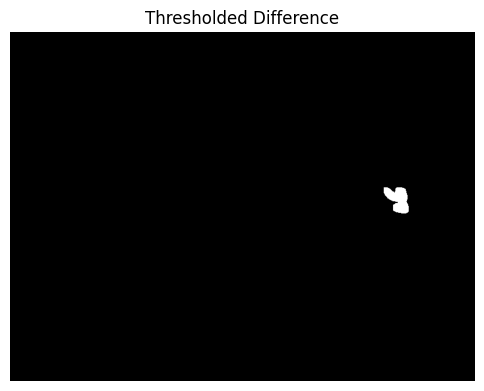

In [77]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def resize_image(image, target_resolution):
    return cv2.resize(image, target_resolution)

# Load two example images
image1 = cv2.imread('c10small\c20_2021_03_25__16_18_36.png')
image2 = cv2.imread('c10small\c20_2021_03_25__16_28_50.png')

# Choose a common target resolution (adjust as needed)
target_resolution = (800, 600)

# Resize images to the common resolution
resized_image1 = resize_image(image1, target_resolution)
resized_image2 = resize_image(image2, target_resolution)

# Set parameters
gaussian_blur_radius_list = [25]
min_contour_area = 1000
black_mask = (5, 10, 5, 0)

# Preprocess images
processed_image1 = preprocess_image_change_detection(resized_image1, gaussian_blur_radius_list, black_mask)
processed_image2 = preprocess_image_change_detection(resized_image2, gaussian_blur_radius_list, black_mask)

# Compare frames
score, contours, thresholded_diff = compare_frames_change_detection(processed_image1, processed_image2, min_contour_area)

# Display the original images
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.title('Image 1')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.title('Image 2')
plt.axis('off')

# Display the processed images
plt.subplot(2, 2, 3)
plt.imshow(processed_image1, cmap='gray')
plt.title('Processed Image 1')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(processed_image2, cmap='gray')
plt.title('Processed Image 2')
plt.axis('off')

plt.show()

# Display the comparison results
print(f"Change Score: {score}")
print(f"Number of Contours: {len(contours)}")

# Draw contours on the original images
contour_image1 = resized_image1.copy()
contour_image2 = resized_image2.copy()
cv2.drawContours(contour_image1, contours, -1, (0, 255, 0), 2)
cv2.drawContours(contour_image2, contours, -1, (0, 255, 0), 2)

# Display the original images with contours
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(contour_image1, cv2.COLOR_BGR2RGB))
plt.title('Contours on Image 1')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(contour_image2, cv2.COLOR_BGR2RGB))
plt.title('Contours on Image 2')
plt.axis('off')

plt.show()

# Display the thresholded difference image
plt.figure(figsize=(6, 6))
plt.imshow(thresholded_diff, cmap='gray')
plt.title('Thresholded Difference')
plt.axis('off')
plt.show()


## **Trial 5**

**Compared Images**

c20_2021_03_25__18_11_35.png

c20_2021_03_25__20_22_51.png

**Parameter Values**

```gaussian_blur_radius_list``` = [9]

```min_contour_area``` = 25

**Observation**

An even lower difference score of 818 was found.

This image reveals the significance of minimum countur area. 

Initially we were not able to discover the change, however after tweaking the gaussian blur radius and contour area to 9 and 25 respectively the function was able to find the contour for change in the image in more distant location from the camera.

We ascertained the values of parameters and also reached closer to a value of contour area for distinguishing the similar and dissimilar images

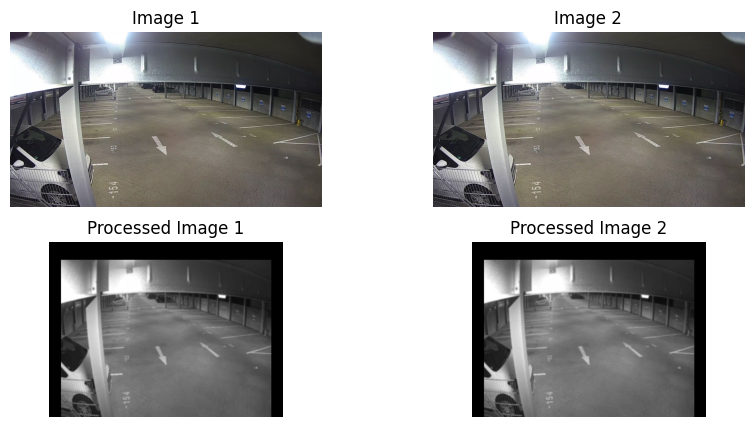

Change Score: 818.5
Number of Contours: 2


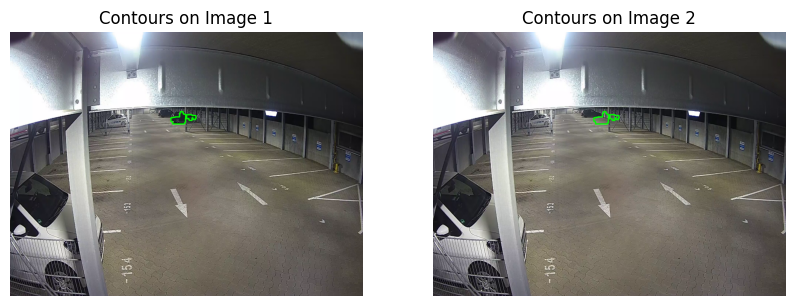

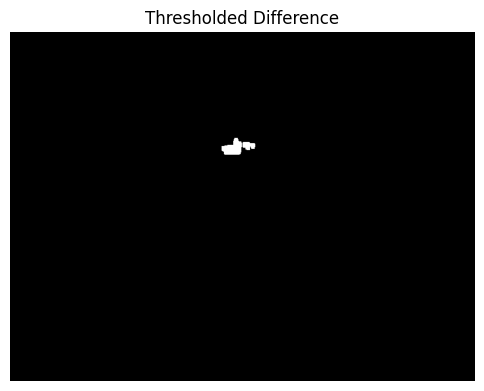

In [86]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def resize_image(image, target_resolution):
    return cv2.resize(image, target_resolution)

# Load two example images
image1 = cv2.imread('c10small\c20_2021_03_25__18_11_35.png')
image2 = cv2.imread('c10small\c20_2021_03_25__20_22_51.png')

# Choose a common target resolution (adjust as needed)
target_resolution = (800, 600)

# Resize images to the common resolution
resized_image1 = resize_image(image1, target_resolution)
resized_image2 = resize_image(image2, target_resolution)

# Set parameters
gaussian_blur_radius_list = [9]
min_contour_area = 25
black_mask = (5, 10, 5, 0)

# Preprocess images
processed_image1 = preprocess_image_change_detection(resized_image1, gaussian_blur_radius_list, black_mask)
processed_image2 = preprocess_image_change_detection(resized_image2, gaussian_blur_radius_list, black_mask)

# Compare frames
score, contours, thresholded_diff = compare_frames_change_detection(processed_image1, processed_image2, min_contour_area)

# Display the original images
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.title('Image 1')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.title('Image 2')
plt.axis('off')

# Display the processed images
plt.subplot(2, 2, 3)
plt.imshow(processed_image1, cmap='gray')
plt.title('Processed Image 1')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(processed_image2, cmap='gray')
plt.title('Processed Image 2')
plt.axis('off')

plt.show()

# Display the comparison results
print(f"Change Score: {score}")
print(f"Number of Contours: {len(contours)}")

# Draw contours on the original images
contour_image1 = resized_image1.copy()
contour_image2 = resized_image2.copy()
cv2.drawContours(contour_image1, contours, -1, (0, 255, 0), 2)
cv2.drawContours(contour_image2, contours, -1, (0, 255, 0), 2)

# Display the original images with contours
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(contour_image1, cv2.COLOR_BGR2RGB))
plt.title('Contours on Image 1')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(contour_image2, cv2.COLOR_BGR2RGB))
plt.title('Contours on Image 2')
plt.axis('off')

plt.show()

# Display the thresholded difference image
plt.figure(figsize=(6, 6))
plt.imshow(thresholded_diff, cmap='gray')
plt.title('Thresholded Difference')
plt.axis('off')
plt.show()


## **Trial 6**

**Compared Images**

c10-1623871124416.png

c10-1623872200494.png

**Parameter Values**

```gaussian_blur_radius_list``` = [9]

```min_contour_area``` = 25

**Observation**

We considered a case of 2 images which are practically similar and hard to distinguish with naked eyes.

Here the Score is 264, however when we look at the contour image, we see that area highlighted is not significant for purposes of car parking applications.

Therefore we conclude that a score of 264 is non significant in terms of similarity. 

In this trial we identified a suitable lower limit for difference score for distinguishing 2 images which is 264.

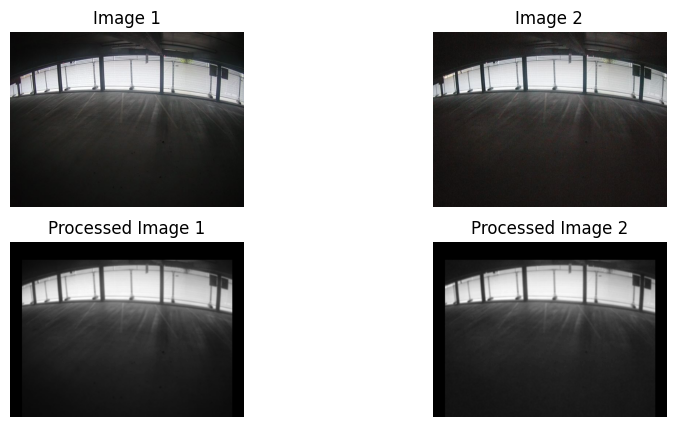

Change Score: 264.0
Number of Contours: 2


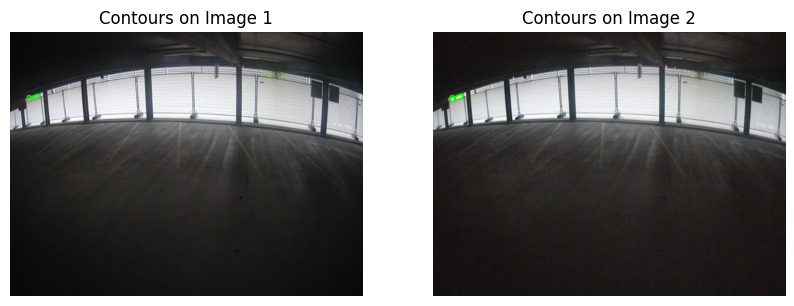

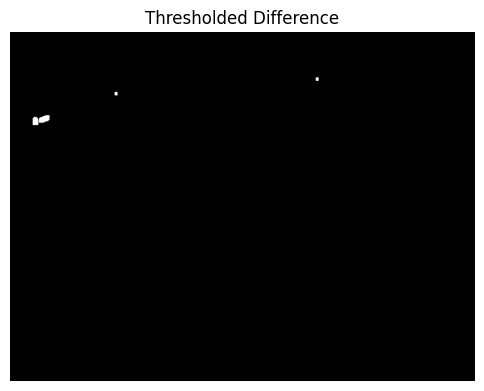

In [87]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def resize_image(image, target_resolution):
    return cv2.resize(image, target_resolution)

# Load two example images
image1 = cv2.imread('c10small\c10-1623871124416.png')
image2 = cv2.imread('c10small\c10-1623872200494.png')

# Choose a common target resolution (adjust as needed)
target_resolution = (800, 600)

# Resize images to the common resolution
resized_image1 = resize_image(image1, target_resolution)
resized_image2 = resize_image(image2, target_resolution)

# Set parameters
gaussian_blur_radius_list = [9]
min_contour_area = 25
black_mask = (5, 10, 5, 0)

# Preprocess images
processed_image1 = preprocess_image_change_detection(resized_image1, gaussian_blur_radius_list, black_mask)
processed_image2 = preprocess_image_change_detection(resized_image2, gaussian_blur_radius_list, black_mask)

# Compare frames
score, contours, thresholded_diff = compare_frames_change_detection(processed_image1, processed_image2, min_contour_area)

# Display the original images
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.title('Image 1')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.title('Image 2')
plt.axis('off')

# Display the processed images
plt.subplot(2, 2, 3)
plt.imshow(processed_image1, cmap='gray')
plt.title('Processed Image 1')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(processed_image2, cmap='gray')
plt.title('Processed Image 2')
plt.axis('off')

plt.show()

# Display the comparison results
print(f"Change Score: {score}")
print(f"Number of Contours: {len(contours)}")

# Draw contours on the original images
contour_image1 = resized_image1.copy()
contour_image2 = resized_image2.copy()
cv2.drawContours(contour_image1, contours, -1, (0, 255, 0), 2)
cv2.drawContours(contour_image2, contours, -1, (0, 255, 0), 2)

# Display the original images with contours
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(contour_image1, cv2.COLOR_BGR2RGB))
plt.title('Contours on Image 1')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(contour_image2, cv2.COLOR_BGR2RGB))
plt.title('Contours on Image 2')
plt.axis('off')

plt.show()

# Display the thresholded difference image
plt.figure(figsize=(6, 6))
plt.imshow(thresholded_diff, cmap='gray')
plt.title('Thresholded Difference')
plt.axis('off')
plt.show()


## **Trial 7**

**Compared Images**

c10-1623871098865.png

c10-1623872200494.png

**Parameter Values**

```gaussian_blur_radius_list``` = [9]

```min_contour_area``` = 25

**Observation**

To estimate a more accurate threshold for Change Score we consider an example of another set of similar images.

Here the Score is 250, however when we look at the contour image, we see that area highlighted is not significant for purposes of car parking applications.

Therefore we conclude that a score of 250 is non significant in terms of similarity. In other words we can treat the 2 images as similar and proceed to delete one of them.

With this trial we ascertained that the previously obtained(trial 6) similarity change score of 264 was good threshold for determining change.

**Finally we concluded that a change score of 300 will serve as a good value for treating the images similar. We will treat all the instances where the score is less than 300 to be similar images and proceed to delete one of the image after that.**

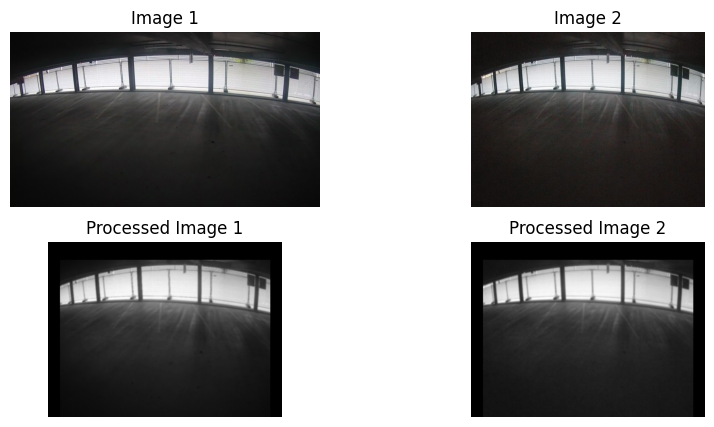

Change Score: 250.0
Number of Contours: 2


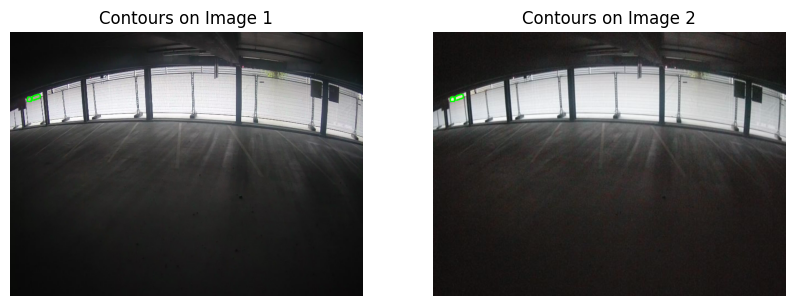

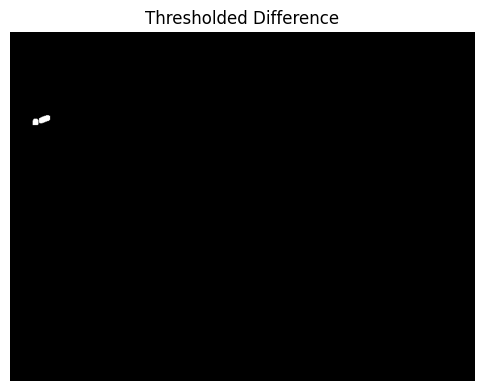

In [89]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def resize_image(image, target_resolution):
    return cv2.resize(image, target_resolution)

# Load two example images
image1 = cv2.imread('c10small\c10-1623871098865.png')
image2 = cv2.imread('c10small\c10-1623872200494.png')

# Choose a common target resolution (adjust as needed)
target_resolution = (800, 600)

# Resize images to the common resolution
resized_image1 = resize_image(image1, target_resolution)
resized_image2 = resize_image(image2, target_resolution)

# Set parameters
gaussian_blur_radius_list = [9]
min_contour_area = 25
black_mask = (5, 10, 5, 0)

# Preprocess images
processed_image1 = preprocess_image_change_detection(resized_image1, gaussian_blur_radius_list, black_mask)
processed_image2 = preprocess_image_change_detection(resized_image2, gaussian_blur_radius_list, black_mask)

# Compare frames
score, contours, thresholded_diff = compare_frames_change_detection(processed_image1, processed_image2, min_contour_area)

# Display the original images
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.title('Image 1')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.title('Image 2')
plt.axis('off')

# Display the processed images
plt.subplot(2, 2, 3)
plt.imshow(processed_image1, cmap='gray')
plt.title('Processed Image 1')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(processed_image2, cmap='gray')
plt.title('Processed Image 2')
plt.axis('off')

plt.show()

# Display the comparison results
print(f"Change Score: {score}")
print(f"Number of Contours: {len(contours)}")

# Draw contours on the original images
contour_image1 = resized_image1.copy()
contour_image2 = resized_image2.copy()
cv2.drawContours(contour_image1, contours, -1, (0, 255, 0), 2)
cv2.drawContours(contour_image2, contours, -1, (0, 255, 0), 2)

# Display the original images with contours
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(contour_image1, cv2.COLOR_BGR2RGB))
plt.title('Contours on Image 1')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(contour_image2, cv2.COLOR_BGR2RGB))
plt.title('Contours on Image 2')
plt.axis('off')

plt.show()

# Display the thresholded difference image
plt.figure(figsize=(6, 6))
plt.imshow(thresholded_diff, cmap='gray')
plt.title('Thresholded Difference')
plt.axis('off')
plt.show()


## **Trial 8**

**Compared Images**

c10-1623871098865.png

c10-1623872200494.png

**Parameter Values**

```gaussian_blur_radius_list``` = [9]

```min_contour_area``` = 25

**Observation**

We added the logic to delete one of the similar images based on the change score value of 300 obtained in trial 7.

The code is able to successfully delete the image : ```c10-1623872200494.png```

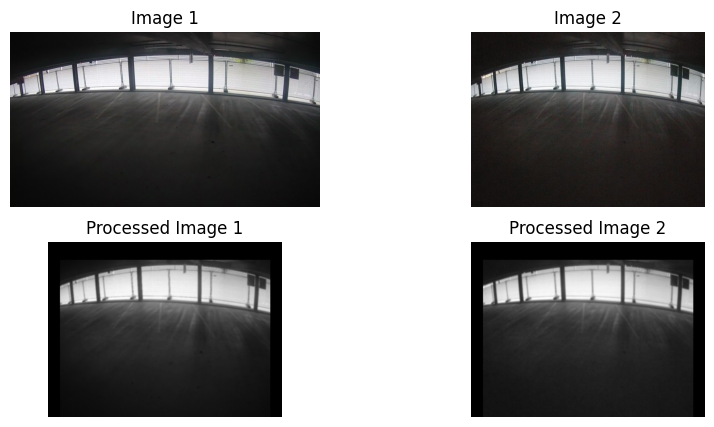

Change Score: 250.0
Number of Contours: 2
Images are identical
deleting duplicate image


In [92]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def resize_image(image, target_resolution):
    return cv2.resize(image, target_resolution)

# Load two example images
image1 = cv2.imread('c10small\c10-1623871098865.png')
image2 = cv2.imread('c10small\c10-1623872200494.png')

# Choose a common target resolution (adjust as needed)
target_resolution = (800, 600)

# Resize images to the common resolution
resized_image1 = resize_image(image1, target_resolution)
resized_image2 = resize_image(image2, target_resolution)

# Set parameters
gaussian_blur_radius_list = [9]
min_contour_area = 25
black_mask = (5, 10, 5, 0)

# Preprocess images
processed_image1 = preprocess_image_change_detection(resized_image1, gaussian_blur_radius_list, black_mask)
processed_image2 = preprocess_image_change_detection(resized_image2, gaussian_blur_radius_list, black_mask)

# Compare frames
score, contours, thresholded_diff = compare_frames_change_detection(processed_image1, processed_image2, min_contour_area)

# Display the original images
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.title('Image 1')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.title('Image 2')
plt.axis('off')

# Display the processed images
plt.subplot(2, 2, 3)
plt.imshow(processed_image1, cmap='gray')
plt.title('Processed Image 1')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(processed_image2, cmap='gray')
plt.title('Processed Image 2')
plt.axis('off')

plt.show()

# Display the comparison results
print(f"Change Score: {score}")
print(f"Number of Contours: {len(contours)}")


if score>300:
    
    # Draw contours on the original images
    contour_image1 = resized_image1.copy()
    contour_image2 = resized_image2.copy()
    cv2.drawContours(contour_image1, contours, -1, (0, 255, 0), 2)
    cv2.drawContours(contour_image2, contours, -1, (0, 255, 0), 2)

    # Display the original images with contours
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(contour_image1, cv2.COLOR_BGR2RGB))
    plt.title('Contours on Image 1')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(contour_image2, cv2.COLOR_BGR2RGB))
    plt.title('Contours on Image 2')
    plt.axis('off')

    plt.show()

    # Display the thresholded difference image
    plt.figure(figsize=(6, 6))
    plt.imshow(thresholded_diff, cmap='gray')
    plt.title('Thresholded Difference')
    plt.axis('off')
    plt.show()
    # if score is less than 300 then ignore the 
else:
    print("Images are identical")
    print("deleting duplicate image") 
    if os.path.exists("c10small\c10-1623872200494.png"):
        os.remove("c10small\c10-1623872200494.png")
    else:
        print("The file does not exist")

## **Trial 9**

**Remove diagram plotting**

Now we only need to evaluate score so we reduce the code by removing the plotting section of the code

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def resize_image(image, target_resolution):
    return cv2.resize(image, target_resolution)

# Load two example images
image1 = cv2.imread('c10small\c10-1623871098865.png')
image2 = cv2.imread('c10small\c10-1623911227602.png')

# Choose a common target resolution (adjust as needed)
target_resolution = (800, 600)

# Resize images to the common resolution
resized_image1 = resize_image(image1, target_resolution)
resized_image2 = resize_image(image2, target_resolution)

# Set parameters
gaussian_blur_radius_list = [9]
min_contour_area = 25
black_mask = (5, 10, 5, 0)

# Preprocess images
processed_image1 = preprocess_image_change_detection(resized_image1, gaussian_blur_radius_list, black_mask)
processed_image2 = preprocess_image_change_detection(resized_image2, gaussian_blur_radius_list, black_mask)

# Compare frames
score, contours, thresholded_diff = compare_frames_change_detection(processed_image1, processed_image2, min_contour_area)

# Display the comparison results
print(f"Change Score: {score}")
print(f"Number of Contours: {len(contours)}")



Change Score: 27436.5
Number of Contours: 20


## **Trial 10**

**Compared Images**

We create a folder of subset of the original dataset 'c20/all' and run the code developed.

**Parameter Values**

```target_resolution``` = (800, 600)

```gaussian_blur_radius_list``` = [9]

```min_contour_area``` = 25

```black_mask``` = (5, 10, 5, 0)

**Observation**

We added error handling capbilities to handle problems while:

1. reading the image files
2. deleting the images based on change scores (which can sometime be none)

We also display the change score for a succesful comparison of two images. We also display initial and final number of files in the directory after a complete evalaution run through the dataset

In [14]:
import cv2
import os

def resize_image(image, target_resolution):
    return cv2.resize(image, target_resolution)

def process_images(image_path1, image_path2, target_resolution, gaussian_blur_radius_list, black_mask, min_contour_area):
    try:
        # Load images
        image1 = cv2.imread(image_path1)
        image2 = cv2.imread(image_path2)

        # Check if images are successfully loaded
        if image1 is None or image2 is None:
            print(f"Error loading images: {image_path1}, {image_path2}")
            return None, None

        # Resize images to the common resolution
        resized_image1 = resize_image(image1, target_resolution)
        resized_image2 = resize_image(image2, target_resolution)

        # Preprocess images
        processed_image1 = preprocess_image_change_detection(resized_image1, gaussian_blur_radius_list, black_mask)
        processed_image2 = preprocess_image_change_detection(resized_image2, gaussian_blur_radius_list, black_mask)

        # Compare frames
        score, contours, _ = compare_frames_change_detection(processed_image1, processed_image2, min_contour_area)

        return score, len(contours)

    except Exception as e:
        print(f"Error processing images: {str(e)}")
        return None, None

# Set parameters
target_resolution = (800, 600)
gaussian_blur_radius_list = [9]
min_contour_area = 25
black_mask = (5, 10, 5, 0)

# Set the target folder containing PNG images
target_folder = 'c20/all'

# Get a list of PNG files in the target folder
png_files = [file for file in os.listdir(target_folder) if file.lower().endswith('.png')]

# Iterate over pairs of images for comparison
for i in range(len(png_files) - 1):
    image_path1 = os.path.join(target_folder, png_files[i])
    image_path2 = os.path.join(target_folder, png_files[i + 1])

    # Process images and get similarity scores
    change_score, num_contours = process_images(image_path1, image_path2, target_resolution, gaussian_blur_radius_list, black_mask, min_contour_area)

    # Delete image2 if the change score is less than 300
    if change_score is not None and change_score < 300:
        try:
            os.remove(image_path1)
            print(f"Deleted {image_path1} due to low change score.")
        except Exception as e:
            print(f"Error deleting {image_path1}: {str(e)}")

    # # Display results if the processing is successful
    if change_score is not None and num_contours is not None:
        print(f"Comparison between {png_files[i]} and {png_files[i + 1]}:")
        print(f"Change Score: {change_score}")
        print("\n")
png_files_post = [file for file in os.listdir(target_folder) if file.lower().endswith('.png')]
print(f'Original number of files: {len(png_files)}')
print(f'Final Number of files: {len(png_files_post)}')

Deleted c20/all\c20-1616768818959.png due to low change score.
Deleted c20/all\c20-1616769161716.png due to low change score.
Deleted c20/all\c20-1616769504539.png due to low change score.
Deleted c20/all\c20-1616771217916.png due to low change score.
Deleted c20/all\c20-1616779784012.png due to low change score.
Deleted c20/all\c20_2021_03_27__09_10_57.png due to low change score.
Deleted c20/all\c20_2021_03_27__09_39_29.png due to low change score.
Deleted c20/all\c20_2021_03_27__10_47_59.png due to low change score.
Deleted c20/all\c20_2021_04_28__05_40_15.png due to low change score.
Deleted c20/all\c20_2021_04_28__13_51_26.png due to low change score.
Original number of files: 324
Final Number of files: 314


# Final code


In the last step We add the logic to ask the user to enter the folder path. 

The code then identifies the similar images based on the criteria of the Score < 300 which was determined to be optimum value from the previous trials(see observations in trial 7). Also the gaussian blur radius was set to 9 from experiments and finally the threshold area for countour was set at 25 to avoid missing out vehicles in the distance from the camera as demontratee in trial 5.

The code successfully reduced the duplicate images. at the beginning of execution there were 1080 images which were systematically evaluated for simialrity thereby reducing the final number of images to 680.

In [15]:
import cv2
import os
import imutils

# Draw a colored mask on the input image based on specified borders.
def draw_color_mask(img, borders, color=(0, 0, 0)):
    h = img.shape[0]
    w = img.shape[1]

    x_min = int(borders[0] * w / 100)
    x_max = w - int(borders[2] * w / 100)
    y_min = int(borders[1] * h / 100)
    y_max = h - int(borders[3] * h / 100)

    img = cv2.rectangle(img, (0, 0), (x_min, h), color, -1)
    img = cv2.rectangle(img, (0, 0), (w, y_min), color, -1)
    img = cv2.rectangle(img, (x_max, 0), (w, h), color, -1)
    img = cv2.rectangle(img, (0, y_max), (w, h), color, -1)

    return img


# Preprocess the input image for change detection.
def preprocess_image_change_detection(img, gaussian_blur_radius_list=None, black_mask=(5, 10, 5, 0)):
    gray = img.copy()
    gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)
    if gaussian_blur_radius_list is not None:
        for radius in gaussian_blur_radius_list:
            gray = cv2.GaussianBlur(gray, (radius, radius), 0)

    gray = draw_color_mask(gray, black_mask)

    return gray


# Compare two frames for change detection.
def compare_frames_change_detection(prev_frame, next_frame, min_contour_area):
    frame_delta = cv2.absdiff(prev_frame, next_frame)
    thresh = cv2.threshold(frame_delta, 45, 255, cv2.THRESH_BINARY)[1]

    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                            cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    score = 0
    res_cnts = []
    for c in cnts:
        if cv2.contourArea(c) < min_contour_area:
            continue

        res_cnts.append(c)
        score += cv2.contourArea(c)

    return score, res_cnts, thresh


###### solution code begins from here ########################

# read image 2 images from the provided image path, resize them to common size, apply gaussian blur, black mask on the edges and calculate difference score
def process_images(image_path1, image_path2, target_resolution, gaussian_blur_radius_list, black_mask, min_contour_area):
    try:
        # Load images
        image1 = cv2.imread(image_path1)
        image2 = cv2.imread(image_path2)

        # Check if images are successfully loaded
        if image1 is None or image2 is None:
            print(f"Error loading images: {image_path1}, {image_path2}")
            return None, None

        # Resize images to the common resolution
        resized_image1 = cv2.resize(image1, target_resolution)
        resized_image2 = cv2.resize(image2, target_resolution)

        # Preprocess images
        processed_image1 = preprocess_image_change_detection(resized_image1, gaussian_blur_radius_list, black_mask)
        processed_image2 = preprocess_image_change_detection(resized_image2, gaussian_blur_radius_list, black_mask)

        # Compare frames
        score, contours, _ = compare_frames_change_detection(processed_image1, processed_image2, min_contour_area)

        return score, len(contours)

    except Exception as e:
        print(f"Error processing images: {str(e)}")
        return None, None

# Set parameters
target_resolution = (800, 600) # common resolution to prevent runtime error with cv2 
gaussian_blur_radius_list = [9] # appropriate chosen blur radius value
min_contour_area = 25 # chosen contour area value for considering significant change
black_mask = (5, 10, 5, 0) # provided by kopernikus

# Ask the user to enter the target folder path
target_folder = input("Enter the target folder path containing PNG images: ")

# Get a list of PNG files in the target folder
png_files = [file for file in os.listdir(target_folder) if file.lower().endswith('.png')]

# Iterate over pairs of images for comparison
for i in range(len(png_files) - 1):
    image_path1 = os.path.join(target_folder, png_files[i])
    image_path2 = os.path.join(target_folder, png_files[i + 1])

    # Process images and get similarity scores
    change_score, num_contours = process_images(image_path1, image_path2, target_resolution, gaussian_blur_radius_list, black_mask, min_contour_area)

    # Delete image2 if the change score is less than 300
    if change_score is not None and change_score < 300:
        try:
            os.remove(image_path1)
            print(f"Deleted {image_path1} due to low change score.")
        except Exception as e:
            print(f"Error deleting {image_path1}: {str(e)}")

    # Display results if the processing is successful
    if change_score is not None and num_contours is not None:
        print(f"Comparison between {png_files[i]} and {png_files[i + 1]}:")
        print(f"Change Score: {change_score}")
        print(f"Number of Contours: {num_contours}")
        print("\n")

png_files_post = [file for file in os.listdir(target_folder) if file.lower().endswith('.png')]
print(f'Original number of png files in the folder {target_folder}: {len(png_files)}')
print(f'Final Number of png files in the folder {target_folder}: {len(png_files_post)}')

Deleted dataset_original_1\c10-1623871098865.png due to low change score.
Comparison between c10-1623871098865.png and c10-1623871124416.png:
Change Score: 0
Number of Contours: 0


Deleted dataset_original_1\c10-1623871124416.png due to low change score.
Comparison between c10-1623871124416.png and c10-1623871168398.png:
Change Score: 0
Number of Contours: 0


Deleted dataset_original_1\c10-1623871168398.png due to low change score.
Comparison between c10-1623871168398.png and c10-1623871512458.png:
Change Score: 0
Number of Contours: 0


Deleted dataset_original_1\c10-1623871512458.png due to low change score.
Comparison between c10-1623871512458.png and c10-1623871856393.png:
Change Score: 0
Number of Contours: 0


Deleted dataset_original_1\c10-1623871856393.png due to low change score.
Comparison between c10-1623871856393.png and c10-1623872200494.png:
Change Score: 0
Number of Contours: 0


Comparison between c10-1623872200494.png and c10-1623872544167.png:
Change Score: 294976.5